# Generate synthetic data stain class

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
%matplotlib inline

In [2]:
data_path = 'data_src/gen/'
newdirs=['linedata','staindata']
imgLab = ['/images' ,'/labels']
for newdir in newdirs:
    os.makedirs(data_path+newdir) if not os.path.exists(data_path+newdir) else None
    os.makedirs(data_path+newdir+imgLab[0]) if not os.path.exists(data_path+newdir+imgLab[0]) else None
    os.makedirs(data_path+newdir+imgLab[1]) if not os.path.exists(data_path+newdir+imgLab[1]) else None

## Generate more lines by transformations 

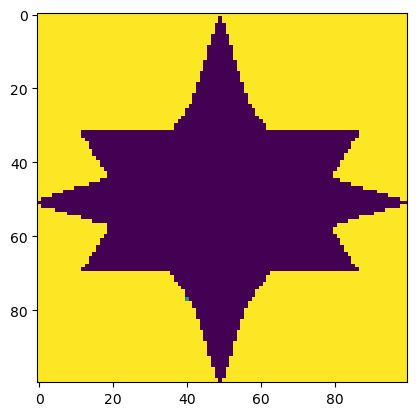

In [3]:
img_dir = 'A:/fabrics/data_src/gen/batch1.png'
img = cv.imread(img_dir)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img)

In [4]:
#temp_images = glob.glob('data_src/gen/temps/*.png')
path = 'A:/fabrics/data_src/gen/stains/'

def save_image(image ,save_idx):
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    cv.imwrite(f'{path}{save_idx}.png', image)
    return save_idx+1

save_idx = 0
for i in range(0,60,25):
    img = cv.cvtColor(cv.imread(img_dir), cv.COLOR_BGR2GRAY)
    img2 = img.copy()
    img[img<255] = i
    save_idx = save_image(img,save_idx)
    img2[img2<255] = 255-i-5
    save_idx = save_image(img2,save_idx)

## load image from templates to test the created labels

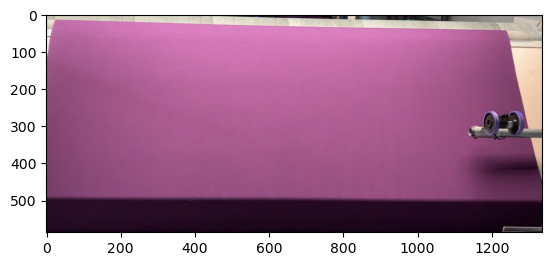

In [5]:
base = cv.imread('A:/fabrics/data_src/gen/temps/12.png')
plt.imshow(base)
plt.show()
base = cv.cvtColor(base, cv.COLOR_BGR2GRAY)

In [6]:
def random_resize(im):
    '''
    resize images by reduce the image sahpe by 30-to-70%.

            Parameters:
                    im (array): image to resize.
            Returns:
                    im (array): resized image.
    '''
    # modfier percentage value to reduce the shape by.
    x_modfier = np.random.randint(40,100)/100
    y_modfier = np.random.randint(40,100)/100
    x,y = im.shape
    x,y = int(x*x_modfier) ,int(y*y_modfier)
    im = cv.resize(im, (x,y), interpolation = cv.INTER_AREA)
    return  im



def add_stain(stain_im,base_im):
    '''
    add line image to the base image and create annotions.

            Parameters:
                    line_im (array): line image.
                    base_im (array): template or defect free image.

            Returns:
                    base_im : new image with defect 
                    label  : bounding box of annotations
    '''
    b_sh = np.array(base_im.shape) -np.array(stain_im.shape)-20
    x1 = np.random.randint(40,b_sh[0]-40)
    y1 = np.random.randint(40,b_sh[1]-40)
    x2 = x1 + stain_im.shape[0]
    y2 = y1 + stain_im.shape[1]
    mask =np.zeros_like(base_im)
    mask[::] = stain_im[10,0]
    mask[x1:x2,y1:y2] = stain_im
    
    base_im = Image.composite(Image.fromarray(base_im) ,Image.fromarray(mask) , Image.fromarray(mask==255))
    base_im = np.array(base_im)
    label = make_labels(x1 ,x2 , y1 ,y2 , base_im.shape, stain_im.shape)
     
    return base_im , label

def make_labels(y1 ,y2 , x1 ,x2 , img_sh,lbl_sh):
    '''
    use the label image to create annotations.

            Parameters:
                    y1 ,y2 , x1 ,x2 (int): image corners coordenats.
                    img_sh (tuble): image shape.
                    lbl_sh (tuble): label shape.

            Returns:
                    list (floats): the bounding box normlized values.
    '''
    x_center = (x2+x1)/(img_sh[1]*2)
    y_center = (y2+y1)/(img_sh[0]*2)
    width = lbl_sh[1]/img_sh[1]
    height = lbl_sh[0]/img_sh[0]
    return [x_center , y_center , width , height]

def write_bb(name,class_num,bbox):
    '''
    weite the bounding boxes values into txt file.

            Parameters:
                    name (array): text file name to save.
                    class_num (int): anotation class.
                    bbox (itterable) : bounding boxes .
        
    '''
    f = open(name, "w")
    f.write(str(class_num)+' ' + ' '.join(map(str, bbox)))
    f.close()
    
def save_image(image ,name):
    '''
    conver image from gray scale to RGB and save it.
            Parameters:
                    image (array): image to save.
                    save_idx (int): image name.

    '''
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
    cv.imwrite(name, image)
    


first get all template (bases) defect free images , and defects and use above functions to create various defect images.
* get base_pathes and defects_pathes and loop over them.
* for each combination save image and annotation file.
* plot first 10 images.

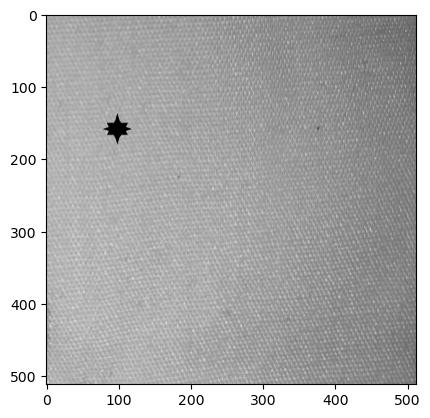

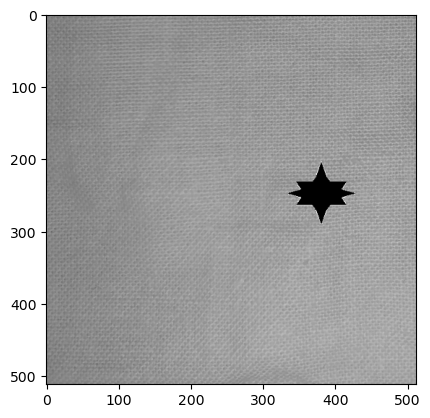

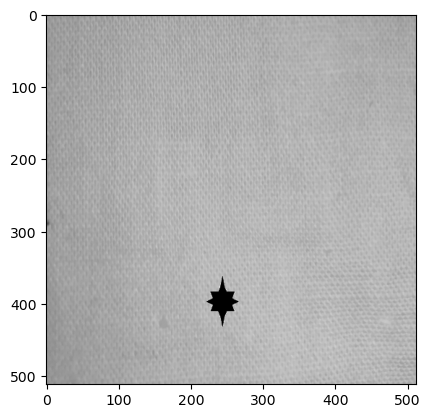

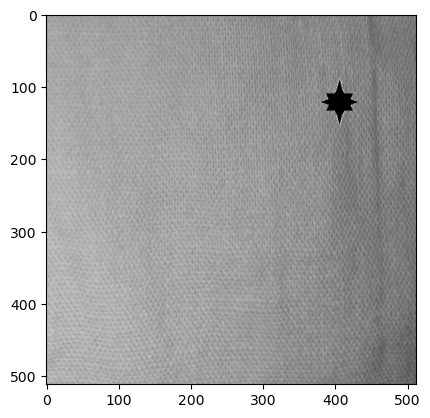

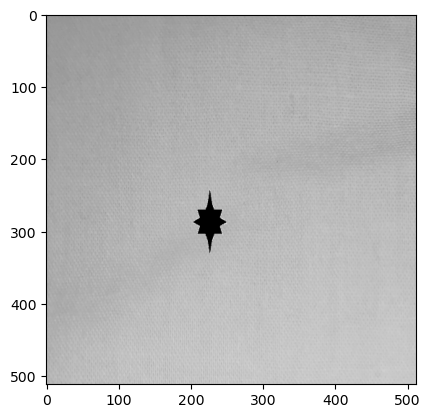

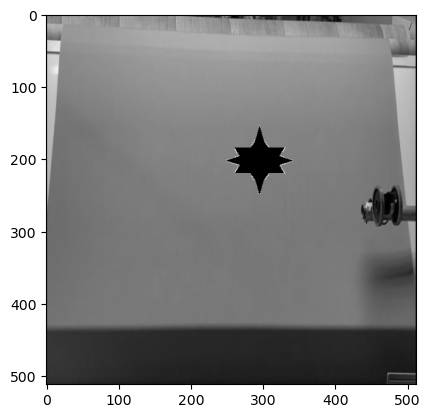

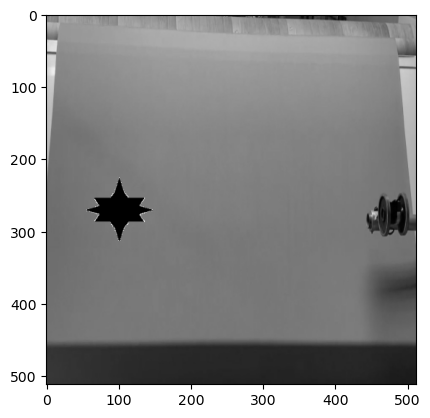

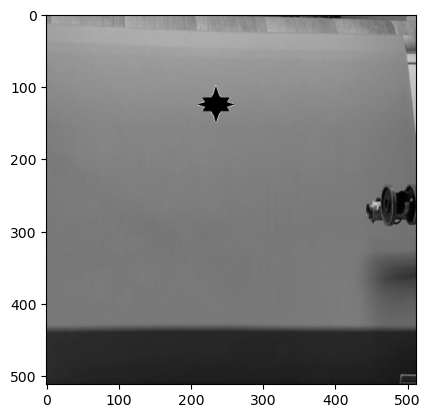

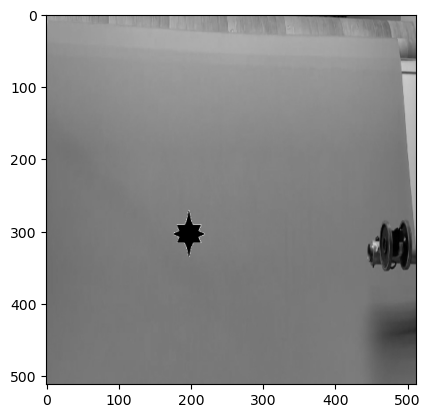

In [7]:
ls =[]
path = ['data_src/gen/staindata/images/' ,'data_src/gen/staindata/labels/' ] 
temp_images = glob.glob('data_src/gen/temps/*.png')
stain_images = glob.glob('data_src/gen/stains/*.png')
idx= 1
for stain_name in stain_images:
    for base_name in temp_images:
        base = cv.imread(base_name)
        base = cv.cvtColor(base, cv.COLOR_BGR2GRAY)
        base = cv.resize(base, (512,512), interpolation = cv.INTER_AREA)
        
        img = cv.imread(stain_name)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = random_resize(img)
        
        base , label = add_stain(img,base)
        ls.append(label)
        if idx < 10: 
            plt.imshow(cv.cvtColor(base, cv.COLOR_GRAY2RGB))
            plt.show()


        im_name = path[0]+f'{str(idx).zfill(4)}.png'
        la_name = path[1]+f'{str(idx).zfill(4)}.txt'
        save_image(base ,im_name)
        write_bb(la_name,0,label)
        idx += 1